In [1]:
import random
import math
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
def MM1(arrival_rate, service_rate, num_customers):
    inter_arrival_times = [random.expovariate(arrival_rate) for _ in range(num_customers)]
    service_times       = [random.expovariate(service_rate) for _ in range(num_customers)]
    arrival_times = []
    start_service_times = []
    finish_service_times = []
    waiting_times = []
    
    current_time = 0
    for i in range(num_customers):
        # 到達時間
        if i == 0:
            arrival_times.append(inter_arrival_times[i])
        else:
            arrival_times.append(arrival_times[i-1] + inter_arrival_times[i])
        
        # 服務開始時間
        start_service_time = max(arrival_times[i], current_time)
        start_service_times.append(start_service_time)
        
        # 服務完成時間
        finish_service_time = start_service_time + service_times[i]
        finish_service_times.append(finish_service_time)
        
        # 等待時間（不含服務）
        waiting_time = start_service_time - arrival_times[i]
        waiting_times.append(waiting_time)
        
        current_time = finish_service_time

    # 統計量
    avg_waiting_time = sum(waiting_times) / num_customers     # Wq
    busy_time = sum(service_times)
    total_time = finish_service_times[-1] - arrival_times[0]

    # 實際到達率 λ̂（這次模擬中的）
    lambda_hat = num_customers / total_time
    # 平均服務時間（樣本） ≈ 1 / service_rate
    avg_service_time = busy_time / num_customers

    Wq = avg_waiting_time
    W  = Wq + avg_service_time
    Lq = lambda_hat * Wq
    L  = lambda_hat * W

    return L, Lq, W, Wq


## Simulation Setup

In [12]:
LAMBDA = 2  # Arrival rate
MU = 4      # Service rate
CUSTOMERS = 1000
num_runs = 500
RO = LAMBDA / MU  # Traffic intensity




In [13]:
def run_experiments(arrival_rate, service_rate, num_customers, num_runs):
    L_list  = []
    Lq_list = []
    W_list  = []
    Wq_list = []

    for _ in range(num_runs):
        L, Lq, W, Wq = MM1(arrival_rate, service_rate, num_customers)
        L_list.append(L)
        Lq_list.append(Lq)
        W_list.append(W)
        Wq_list.append(Wq)

    return L_list, Lq_list, W_list, Wq_list


In [14]:

L_list, Lq_list, W_list, Wq_list = run_experiments(arrival_rate=LAMBDA, service_rate=MU,
                                                   num_customers=CUSTOMERS, num_runs=num_runs)


In [15]:
def mean_and_ci(data, confidence=0.95):
    n = len(data)
    mean = sum(data) / n

    # 樣本標準差
    var = sum((x - mean) ** 2 for x in data) / (n - 1)
    s = math.sqrt(var)

    # z 值（這裡直接用常態近似）
    if confidence == 0.95:
        z = 1.96
    elif confidence == 0.99:
        z = 2.576
    else:
        # 簡單處理，真要精確可以自己查 z 表
        z = 1.96  

    half_width = z * s / math.sqrt(n)
    lower = mean - half_width
    upper = mean + half_width
    return mean, (lower, upper)


In [16]:
mean_Wq, ci_Wq = mean_and_ci(Wq_list, confidence=0.95)
mean_L,  ci_L  = mean_and_ci(L_list,  confidence=0.95)

print("Wq 平均 =", mean_Wq, ", 95% CI =", ci_Wq)
print("L  平均 =", mean_L,  ", 95% CI =", ci_L)


Wq 平均 = 0.2525793211335252 , 95% CI = (0.24841665587840386, 0.25674198638864654)
L  平均 = 1.0090512435648913 , 95% CI = (0.9982841695628308, 1.0198183175669517)


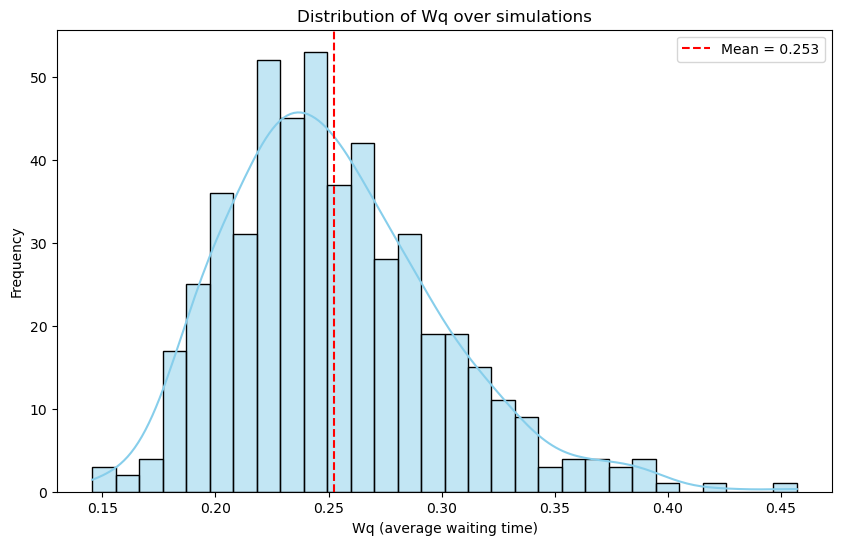

In [17]:

plt.figure(figsize=(10,6))
sns.histplot(Wq_list, bins=30, kde=True, color="skyblue")
plt.axvline(np.mean(Wq_list), color='red', linestyle='--', label=f"Mean = {np.mean(Wq_list):.3f}")
plt.title("Distribution of Wq over simulations")
plt.xlabel("Wq (average waiting time)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


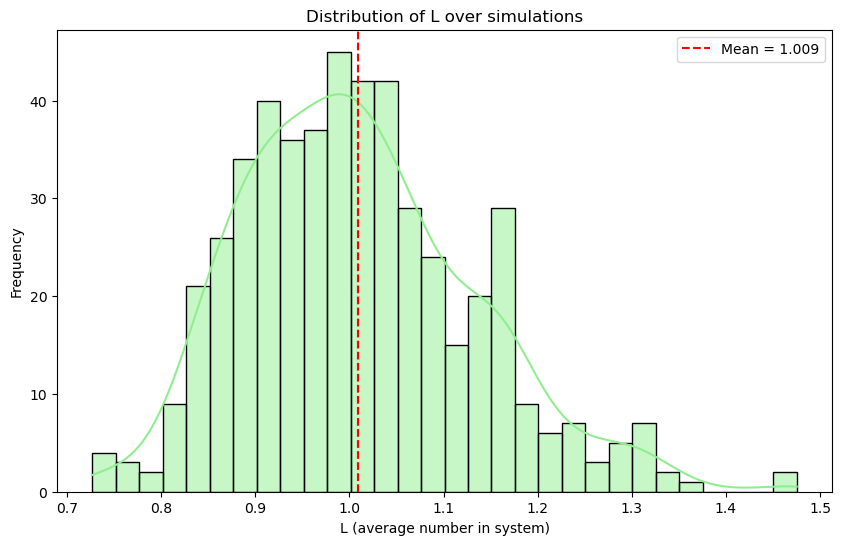

In [18]:
plt.figure(figsize=(10,6))
sns.histplot(L_list, bins=30, kde=True, color="lightgreen")
plt.axvline(np.mean(L_list), color='red', linestyle='--', label=f"Mean = {np.mean(L_list):.3f}")
plt.title("Distribution of L over simulations")
plt.xlabel("L (average number in system)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


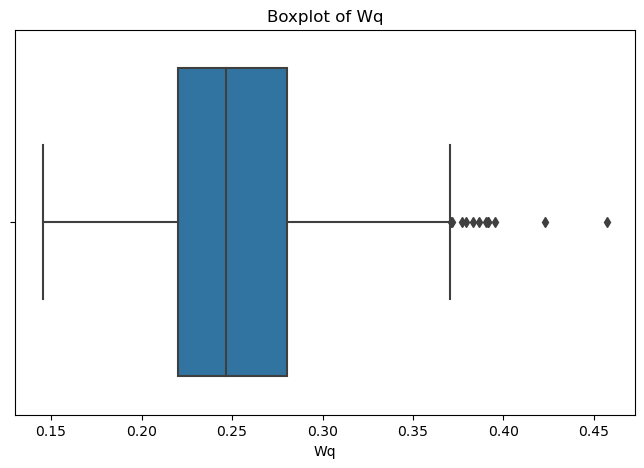

In [19]:
plt.figure(figsize=(8,5))
sns.boxplot(x=Wq_list)
plt.title("Boxplot of Wq")
plt.xlabel("Wq")
plt.show()


In [21]:
import scipy.stats as st

mean_Wq = np.mean(Wq_list)
std_Wq  = np.std(Wq_list, ddof=1)
ci_low, ci_high = st.t.interval(confidence=0.95, df=num_runs-1, loc=mean_Wq, scale=std_Wq/np.sqrt(num_runs))

print("Mean Wq =", mean_Wq)
print("95% CI =", (ci_low, ci_high))


Mean Wq = 0.252579321133525
95% CI = (0.24840661155618823, 0.2567520307108618)
